In [1]:
# import packages
import time
from datetime import timedelta, datetime, date
import arrow 
import pdb
import glob 

from os.path import join
import os
from os import listdir
from os.path import isfile, join
import csv

import numpy as np
import numpy.matlib
import pandas as pd

from timeit import default_timer as timer

import io
from runeq import Config, stream

import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline

'''
print('Download runeq, via Terminal: pip install runeq')
Rune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md
documentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
Make sure that runeq is up-to-date before you run by running: 
pip install pipupgrade
pipupgrade --verbose --latest --yes

'''



"\nprint('Download runeq, via Terminal: pip install runeq')\nRune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md\ndocumentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb\nMake sure that runeq is up-to-date before you run by running: \npip install pipupgrade\npipupgrade --verbose --latest --yes\n\n"

# Compare availibility of AppleWatch and RCS-data over time

Notebook does not download data, only visualizes availbale epochs.

Code requires on folder 'config files' in main path, containing the configuration files for each specific patient. Documentation about how to create these files is given on the Rune-Github: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb.

In [3]:
# set the path to the directory in which the repo exists 
path = os.path.dirname(os.getcwd())
print(path)

/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection


In [27]:
# set up config for Rune RCS data extraction
# The Device-ID's differ from the Apple-watch device IDs!! 

# (https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb)


'''
Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
go to Clients; make new Client; copy keys to yaml-file
'''

cfg_RCS02 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS02.yaml'))
cfg_RCS05 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS05.yaml'))
cfg_RCS06 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS06.yaml'))
cfg_RCS07 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS07.yaml'))

clients = {'RCS02' : stream.V1Client(cfg_RCS02),
           'RCS05' : stream.V1Client(cfg_RCS05),
          'RCS06': stream.V1Client(cfg_RCS06),
           'RCS07': stream.V1Client(cfg_RCS07)}

# device_ids are ID's for patient's RCS's, for all patient right-sided RCS
deviceIDS = {
    'RCS02': {'RCS_right':'DeviceNPC700404H', 
              'RCS_left': 'DeviceNPC700398H',
              'Watch': 'S9Nj2M1Q'},
    'RCS05': {'RCS_right': 'DeviceNPC700415H', 
              'RCS_left': 'DeviceNPC700414H',
              'Watch': 'fkFVvXvO'},
    'RCS06': {'RCS_right': 'NPC700425H',
              'RCS_left': 'NPC700424H', 
              'Watch': 'CWTFFG3f'},
    'RCS07': {'RCS_right': 'NPC700403H',
              'RCS_left': 'NPC700419H',
             'Watch': '0Z48CCdv'}
            }


In [40]:
def check_data_availability(pt, y0,m0,d0,y1,m1,d1):
    '''
    Finds data availability within some time frame.
    Input:
    - pt = patient string (e.g. 'RCS02' or 'RCS05')
    - y0,m0,d0 : start date of desired timeperiod (year, month, date, e.g. 2020, 5, 1)
    - y1,m1,d1 : end date of desired timeperiod (year, month, date, e.g. 2020, 6, 1)
    
    Outputs: dataframe with 0's and 1's for data availability at certain timestamps
    
    Configurations for extraction via Rune platform
    Source: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
    
    Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
    To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
    go to Clients; make new Client; copy keys to yaml-file
    '''
    # set timestamps of requested timespan
    start = datetime(y0,m0,d0).timestamp()
    end = datetime(y1,m1,d1).timestamp()

    # set download parameters with set start and endtimes
    params = {'device_id': deviceIDS[pt]['RCS_left'], 
                          'start_time': start,
                          'end_time': end, 
                          'channels': '0,1,2,3',
                          'resolution': 60*24, # time in sec
                          'timestamp': 'unix'}
#     # set download parameters with set start and endtimes
#     downloadParameters = {'device_id': deviceIDS[pt]['RCS_right'], 
#                           'start_time': start,
#                           'end_time': end, 
#                           'timestamp': 'unix'}
    
    accessor = clients[pt].LFP(expression='availability(lfp)', **params)
    
    rcs_left = pd.DataFrame()
    for page in accessor.iter_json_availability():
        df_page = pd.DataFrame() 
        for idx, key in enumerate(page['data'].keys()):      
            df_page.insert(idx, key, page['data'][key])
        df_page.insert(0, 'time', page['time']) 
        rcs_left = rcs_left.append(df_page, ignore_index=True)
    
    '''
    Finds accel data availability within some time frame
    Outputs: dataframe with 0's and 1's for data availability at certain timestamps
    '''
    # set download parameters with set start and endtimes
    params = {'device_id': deviceIDS[pt]['Watch'], 
                          'start_time': start,
                          'end_time': end, 
                          'resolution': 60*24, # time in sec
                          'timestamp': 'unix'}
    accessor = clients[pt].Accel(expression='availability(accel)', **params)
    
    watch = pd.DataFrame()
    for page in accessor.iter_json_availability():
        watch = pd.DataFrame(page['availability(accel)']) 
        watch.insert(0, 'time', page['time']) 
    
    return rcs_left, watch



In [66]:
def find_epochs(timestamp_series, state_series, state_match):
    '''
    Returns start/stop time of data epochs based off state changes
    For example, we want to find all data epochs in which sampling rate == 250 
    Each epoch starts when the first sampling rate event == 250 
    Each epoch ends when sampling rate changes to different value
    
    Input: 
        time_series - unix time stamps for each state <pd series>
        state_series - values for a particular state <pd series>
        state_match - desired state value <int, float, or string>
    Output: 
        epochs - list of unix time stamps for epoch start/stop
    '''
   
    # calculate changes in adjacent values to identify state changes
    match = pd.DataFrame([1 if x == state_match else 0 for x in state_series])
    match['change'] = match.diff()
    
    # when 'change' is 0, then a current value is identical to the previous value
    # an epoch begins when the change value is 1
    # an epoch ends when the change value is -1
    start_idx = [((np.isnan(x) and y == 1) or x == 1) for x,y in zip(match['change'],match[0])]
    stop_idx = [x == -1 for x in match['change']]
    
    # obtain datetime stamps for the start and stop of all epochs
    window_start = timestamp_series[start_idx]
    window_stop = timestamp_series[stop_idx]

    # if the last epoch has no stop, add the last datetime stamp as the stop
    if len(window_start) > len(window_stop):
        window_stop.loc[len(window_stop)] = timestamp_series.iloc[-1]
        
    # make array of start/stop times
    epochs = np.array([window_start[:], window_stop[:]]).transpose()

    return epochs


def find_overlapping_epochs(*conditions):
    '''
    Return epochs where all conditions are true.

    Input:
        One or more conditions. Each condition is a list of epochs.
        Each epoch is a list/tuple with 2 elements: the start and
        end time of a time interval where the condition was true.

    Output:
        A list of tuples, where each tuple represents the start and
        end time of an epoch where all the conditions are true
    '''

    # Compile a set of all the timestamps (the start times AND
    # end times of any of our conditions).
    times = set()

    # Also create a dictionary that summarizes the overall change at
    # each timestamp: the net number of conditions that "turn on" (or
    # "become" true).
    change_at_time = defaultdict(int)

    for condition in conditions:
        for epoch in condition:
            start, end = epoch
            times.add(start)
            times.add(end)
            # When a condition starts, the change at time t is positive
            change_at_time[start] += 1
            # When a condition ends, the change at time t is negative
            change_at_time[end] -= 1

    results = []

    # Now go through the timestamps *in order*, and keep track of
    # the cumulative sum of change_at_time:
    num_on = 0

    num_conditions = len(conditions)

    # When we find a timestamp where all of the conditions are true
    # (i.e. cumulative sum = num_conditions), we'll keep track of the
    # start time:
    current_epoch_start = None

    for time in sorted(times):
        num_on += change_at_time[time]
        if num_on == num_conditions and current_epoch_start == None:
            current_epoch_start = time

        if num_on != num_conditions and current_epoch_start != None:
            results.append((current_epoch_start, time))
            current_epoch_start = None

    if not results:
        print('No epochs matching all criteria')

    return results


def plot_epochs(condition_names, *conditions):
    '''
    Plots one or more conditions and the times in which those conditions were met

    Input:
        List of condition names and list of start/end times for epochs matching each condition
    '''

    num_conditions = len(conditions)

    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, condition in enumerate(conditions):
        for epoch in condition:
            ax.plot([datetime.fromtimestamp(epoch[0]), datetime.fromtimestamp(epoch[1])], [idx, idx],
                    linewidth=25)

    plt.xticks(rotation=90)
    plt.yticks(np.arange(num_conditions), condition_names)
    plt.tight_layout()
    plt.xlabel('Time')
    plt.ylabel('Filter Criteria')
    plt.title('Data Availability')

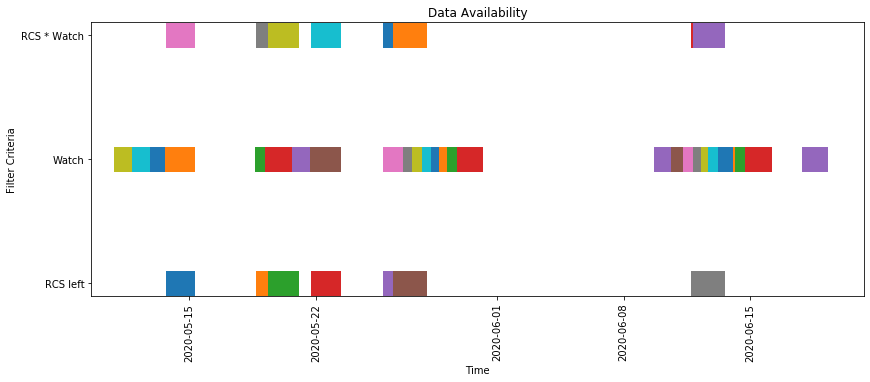

In [71]:
# Call function
rcs_left, watch = check_data_availability('RCS02', 2020,5,1,2020,6,30)

both_avail = rcs_left.time[(rcs_left['channel.0'] == 1) & (watch[0] ==1)]
# set up dataframe for find_epochs
epochs_both = pd.DataFrame(data = rcs_left['time'], columns=['time'])
epochs_both['state'] = np.zeros(epochs_both.shape[0])
for idx in np.arange(len(both_avail)):
    epochs_both.at[both_avail.index[idx],'state'] = 1

# find epochs
epochs_both = find_epochs(epochs_both.time, epochs_both.state, 1)
epochs_neural = find_epochs(rcs_left.time,rcs_left['channel.0'], 1)
epochs_accel = find_epochs(watch.time,watch[0], 1)

# plot data availability
plot_epochs(['RCS left','Watch','RCS * Watch'], epochs_neural,epochs_accel,epochs_both)



## Code below is to include more specific availibility details later

In [33]:
def downloadData(pt,y0,m0,d0,y1,m1,d1):
    '''
    Function downloads csv files with RCS accelerometry (always with gravity, no internal
    filtering), or neural data for seperate days, within a given time period.
    Input:
    - pt = patient string (e.g. 'RCS02' or 'RCS05')
    - y0,m0,d0 : start date of desired timeperiod (year, month, date, e.g. 2020, 5, 1)
    - y1,m1,d1 : end date of desired timeperiod (year, month, date, e.g. 2020, 6, 1)
    
    Saves csv files in patient folder within given path-folder.
    '''
    
    '''
    Configurations for extraction via Rune platform
    Source: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
    
    Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
    To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
    go to Clients; make new Client; copy keys to yaml-file
    '''
    # set timestamps of requested timespan
    start = datetime(y0,m0,d0).timestamp()
    end = datetime(y1,m1,d1).timestamp()
    
    # create dict to store different data
    data = {}
    
    ### Download available RCS neural-data ###
    
    ## Right RCS side ##
    
    # set download parameters with set start and endtimes
    downloadParameters = {'device_id': deviceIDS[pt]['RCS_left'], 
                          'start_time': start,
                          'end_time': end, 
                          'timestamp': 'unix'}


    # define adaptive information that is desired
    adaptive_fields = {
        'event': 'stimulation_state.adaptive',
        'fields': 'adaptive_state,'
                'ld0.threshold.high,'
                  'ld0.threshold.low,'
                  'ld0.output,'
                'ld1.threshold.high,'
                  'ld1.threshold.low,'
                  'ld1.output,'
                  }
    accessor = clients[pt].State( **downloadParameters, **adaptive_fields  )
    # Extraction of Rune function
    RCS_neural_right = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        RCS_neural_right = RCS_neural_right.append(page_df, ignore_index=True)    
    data['RCS_neural_right']: RCS_neural_right
    
    ## Left RCS side ##
    
    # set download parameters with set start and endtimes
    downloadParameters = {'device_id': deviceIDS[pt]['RCS_right'], 
                          'start_time': start,
                          'end_time': end, 
                          'timestamp': 'unix'}

    # define adaptive information that is desired
    adaptive_fields = {
        'event': 'stimulation_state.adaptive',
        'fields': 'adaptive_state,'
                'ld0.threshold.high,'
                  'ld0.threshold.low,'
                  'ld0.output,'
                'ld1.threshold.high,'
                  'ld1.threshold.low,'
                  'ld1.output,'
                  }
    accessor = clients[pt].State( **downloadParameters, **adaptive_fields  )
    
    # Extraction of Rune function
    RCS_neural_left = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        RCS_neural_left = RCS_neural_left.append(page_df, ignore_index=True) 
    data['RCS_neural_left']: RCS_neural_left
    
    ### Download available RCS-accelerometer data ###
    
    # set download parameters with set start and endtimes
    downloadParameters = {'device_id': deviceIDS[pt]['RCS_right'], 
                          'start_time': start,
                          'end_time': end, 
                          'timestamp': 'unix'}
    
    accessor = clients[pt].Accel(**downloadParameters, expression= "accel" )
    # Extraction of Rune function
    RCS_acc_right = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        RCS_acc_right = RCS_acc_right.append(page_df, ignore_index=True)
    data['RCS_acc_right']: RCS_acc_right
    
    ### Download available AppleWatch-data ###
    # set download parameters with set start and endtimes, for all watch functions
    downloadParameters = {'device_id': deviceIDS[pt]['Watch'], 
                          'start_time': start,
                          'end_time': end, 
                          'timestamp': 'unix'}
    
    ## Accelerometry ##
    # set download parameters with specific device, start and end date
    accessor = clients[pt].Accel(**downloadParameters, expression= "user" )
    # Extraction of Rune function
    watch_Acc = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        watch_Acc = watch_Acc.append(page_df, ignore_index=True)
    data['watch_Acc']: watch_Acc
    
    ## Tremor score ##
    accessor = clients[pt].ProbabilitySymptom(symptom='tremor', severity='*',
                                     page_size=10000,**downloadParameters, resolution=60) # resolution is time interval in sec between points
    watch_tremor = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        watch_tremor = watch_tremor.append(page_df, ignore_index=True)
    data['watch_tremor']: watch_tremor
    
    ## Dyskinesia ##
    accessor = clients[pt].ProbabilitySymptom(symptom='dyskinesia', **downloadParameters,
                                         page_size=10000,resolution=60) 
    watch_dyskinesia = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        watch_dyskinesia = watch_dyskinesia.append(page_df, ignore_index=True)
    data['watch_dyskinesia']: watch_dyskinesia
    
        
    
    return data



In [69]:
# starttime = timer()
# data = downloadData(pt='RCS02', y0=2020, m0=6, d0=10, y1=2020, m1=6, d1=12)
# endtime = timer()
# print('time elapsed (sec):', endtime-starttime)
